<a href="https://colab.research.google.com/github/Parth-nXp/TDNN_mini_projects/blob/main/climate_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
! pip install opendatasets --quiet
! pip install torchinfo --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data")

Skipping, found downloaded files in "./daily-climate-time-series-data" (use force=True to force download)


In [59]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchinfo import summary
from torch.optim import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [60]:
df_train = pd.read_csv("/content/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("/content/daily-climate-time-series-data/DailyDelhiClimateTest.csv")
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [61]:
series_train = df_train['meantemp'].values.reshape(-1,1).astype(np.float32)
series_test = df_test['meantemp'].values.reshape(-1,1).astype(np.float32)

s_min, s_max = series_train.min(), series_train.max()
series_train = (series_train - s_min) / (s_max - s_min)
series_test = (series_test - s_min) / (s_max - s_min)

In [62]:
class ClimateDataset(Dataset):
  def __init__(self, series, window_size):
    self.series = torch.tensor(series)
    self.window_size = window_size

  def __len__(self):
    return len(self.series) - self.window_size

  def __getitem__(self, idx):
    x = self.series[idx : idx + self.window_size]
    y = self.series[idx + self.window_size]
    return x, y

In [63]:
train_dataset = ClimateDataset(series_train, window_size= 7)
test_dataset = ClimateDataset(series_test, window_size= 7)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [64]:
class LSTMModel(nn.Module):
  def __init__(self, input_size = 1, hidden_size = 64, num_layers = 1):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = out[:, -1, :]
    out = self.linear(out)
    return out

model = LSTMModel().to(device)

In [65]:
summary(model, input_size = (128, 7, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [128, 1]                  --
├─LSTM: 1-1                              [128, 7, 64]              17,152
├─Linear: 1-2                            [128, 1]                  65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 15.38
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.07
Estimated Total Size (MB): 0.53

In [66]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr = 0.001)

In [67]:
total_loss_plot_train = []
total_loss_plot_test = []

epochs = 200

for epoch in range(epochs):
  total_loss_train = 0
  total_loss_test = 0
  model.train()
  for batch_x, batch_y in train_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    prediction = model(batch_x)
    batch_loss = criterion(prediction, batch_y)
    total_loss_train += batch_loss.item()

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  with torch.no_grad():
    model.eval()
    for batch_x, batch_y in test_loader:
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      prediction = model(batch_x)
      batch_loss = criterion(prediction, batch_y)
      total_loss_test += batch_loss.item()

  total_loss_plot_train.append(total_loss_train / len(train_loader))
  total_loss_plot_test.append(total_loss_test / len(test_loader))

  if epoch % 10 == 0:
    print(f"Epoch: {epoch + 1}, Training Loss: {total_loss_plot_train[-1]}, Testing Loss: {total_loss_plot_test[-1]}")
    print("="*40)

Epoch: 1, Training Loss: 0.1992882862687111, Testing Loss: 0.06677001714706421
Epoch: 11, Training Loss: 0.0049557436335211, Testing Loss: 0.006287674885243177
Epoch: 21, Training Loss: 0.004196202848106623, Testing Loss: 0.005697780288755894
Epoch: 31, Training Loss: 0.0039478093579721945, Testing Loss: 0.005530569236725569
Epoch: 41, Training Loss: 0.003848343602536867, Testing Loss: 0.005402868613600731
Epoch: 51, Training Loss: 0.0035557639009008804, Testing Loss: 0.004816782660782337
Epoch: 61, Training Loss: 0.0033743391977623105, Testing Loss: 0.004596561659127474
Epoch: 71, Training Loss: 0.0031931374687701464, Testing Loss: 0.004147013183683157
Epoch: 81, Training Loss: 0.0030576794718702636, Testing Loss: 0.0038930370938032866
Epoch: 91, Training Loss: 0.002976410052118202, Testing Loss: 0.0035091007594019175
Epoch: 101, Training Loss: 0.0027523685906392834, Testing Loss: 0.0031732525676488876
Epoch: 111, Training Loss: 0.0026447627460584044, Testing Loss: 0.00304779503494501

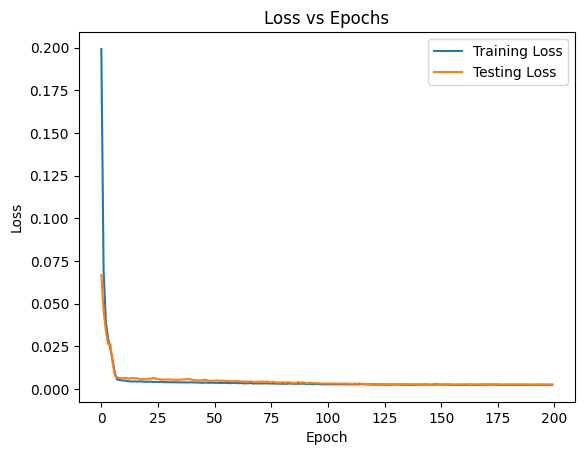

In [70]:
plt.plot(total_loss_plot_train, label = "Training Loss")
plt.plot(total_loss_plot_test, label = "Testing Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()